In [700]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import os
import seaborn as sns
import pims
import pySPM as spm 
import trackpy as tp
import glob
from sxmreader import SXMReader

In [922]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel
frames = gray(pims.open('step_dists3/*.jpg'))

# n_range = range(4, 14)
# N = len(n_range)
# BASE_FILENAME = "electromigration_12/Image_{0:03}.sxm"
# SXM_PATH = [BASE_FILENAME.format(i) for i in n_range]
# frames = SXMReader(SXM_PATH)
molecule_size = 5
min_mass = 6000
max_mass = 12000
min_size = 1
max_ecc = 1
separation = 5
# searchRange = 20
# frames_1 = [];
# for i in range(len(frames)):
#     frames_1.append(frames[i])        
f = tp.batch(frames[:], molecule_size, minmass=30, separation=13)
#tp.quiet()  # Turn off progress reports for best performance

Frame 3: 20 features


<Figure size 720x360 with 0 Axes>

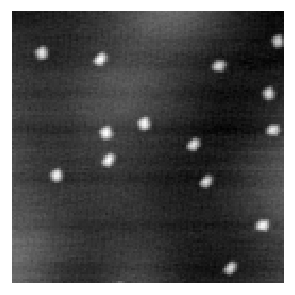

In [923]:
plt.figure()

fig=plt.figure(figsize=(4, 3), dpi=120)
ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
ln, = ax1.plot([], [], lw=3)
plt.axis('off')

def update(i):
#     tp.annotate(f[f['frame']==i], frames[i],  plot_style={'markersize': 1}, ax=ax1)
    tp.annotate(f[f['frame']==i], frames_1[i],  plot_style={'markersize': 1}, ax=ax1)
    for line in ax1.lines[:-1]:
        line.set_marker(None)
    return ln,

ani = FuncAnimation(fig, update, frames=range(len(frames)), interval=500)
ani

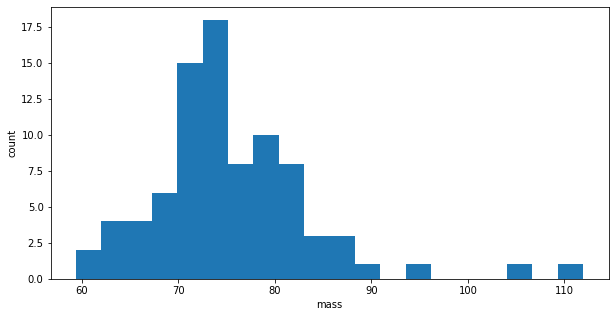

In [894]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

Frame 3: 20 trajectories present.


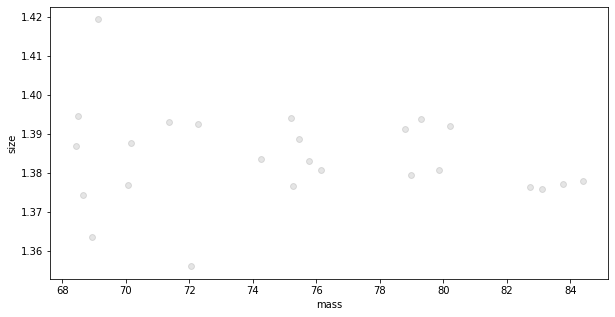

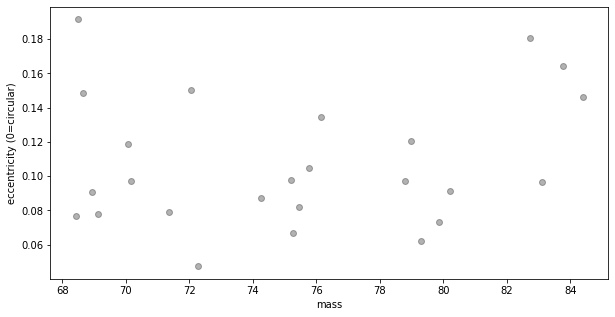

In [910]:
t = tp.link(f, search_range=100, adaptive_stop=10, memory=3)
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [911]:
t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
         (t['ecc'] < max_ecc))]
t2 = tp.filter_stubs(t, 1)

# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 25
After: 25


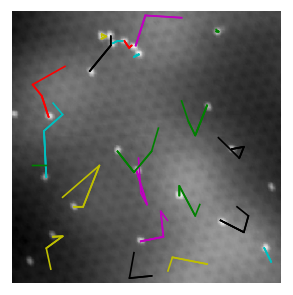

In [912]:
rc('animation', html='html5')
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

fig=plt.figure(figsize=(4, 3), dpi=120)
ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
plt.axis('off')
ln, = ax1.plot([], [], lw=3)
ax1.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'k'])

def update(i):
    tp.plot_traj(t2[(t2['frame']<=i)], superimpose=frames[i], label=False, ax=ax1)
    ax1.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'k'])
    return ln,

ani = FuncAnimation(fig, update, frames=range(len(frames)), interval=500)
ani

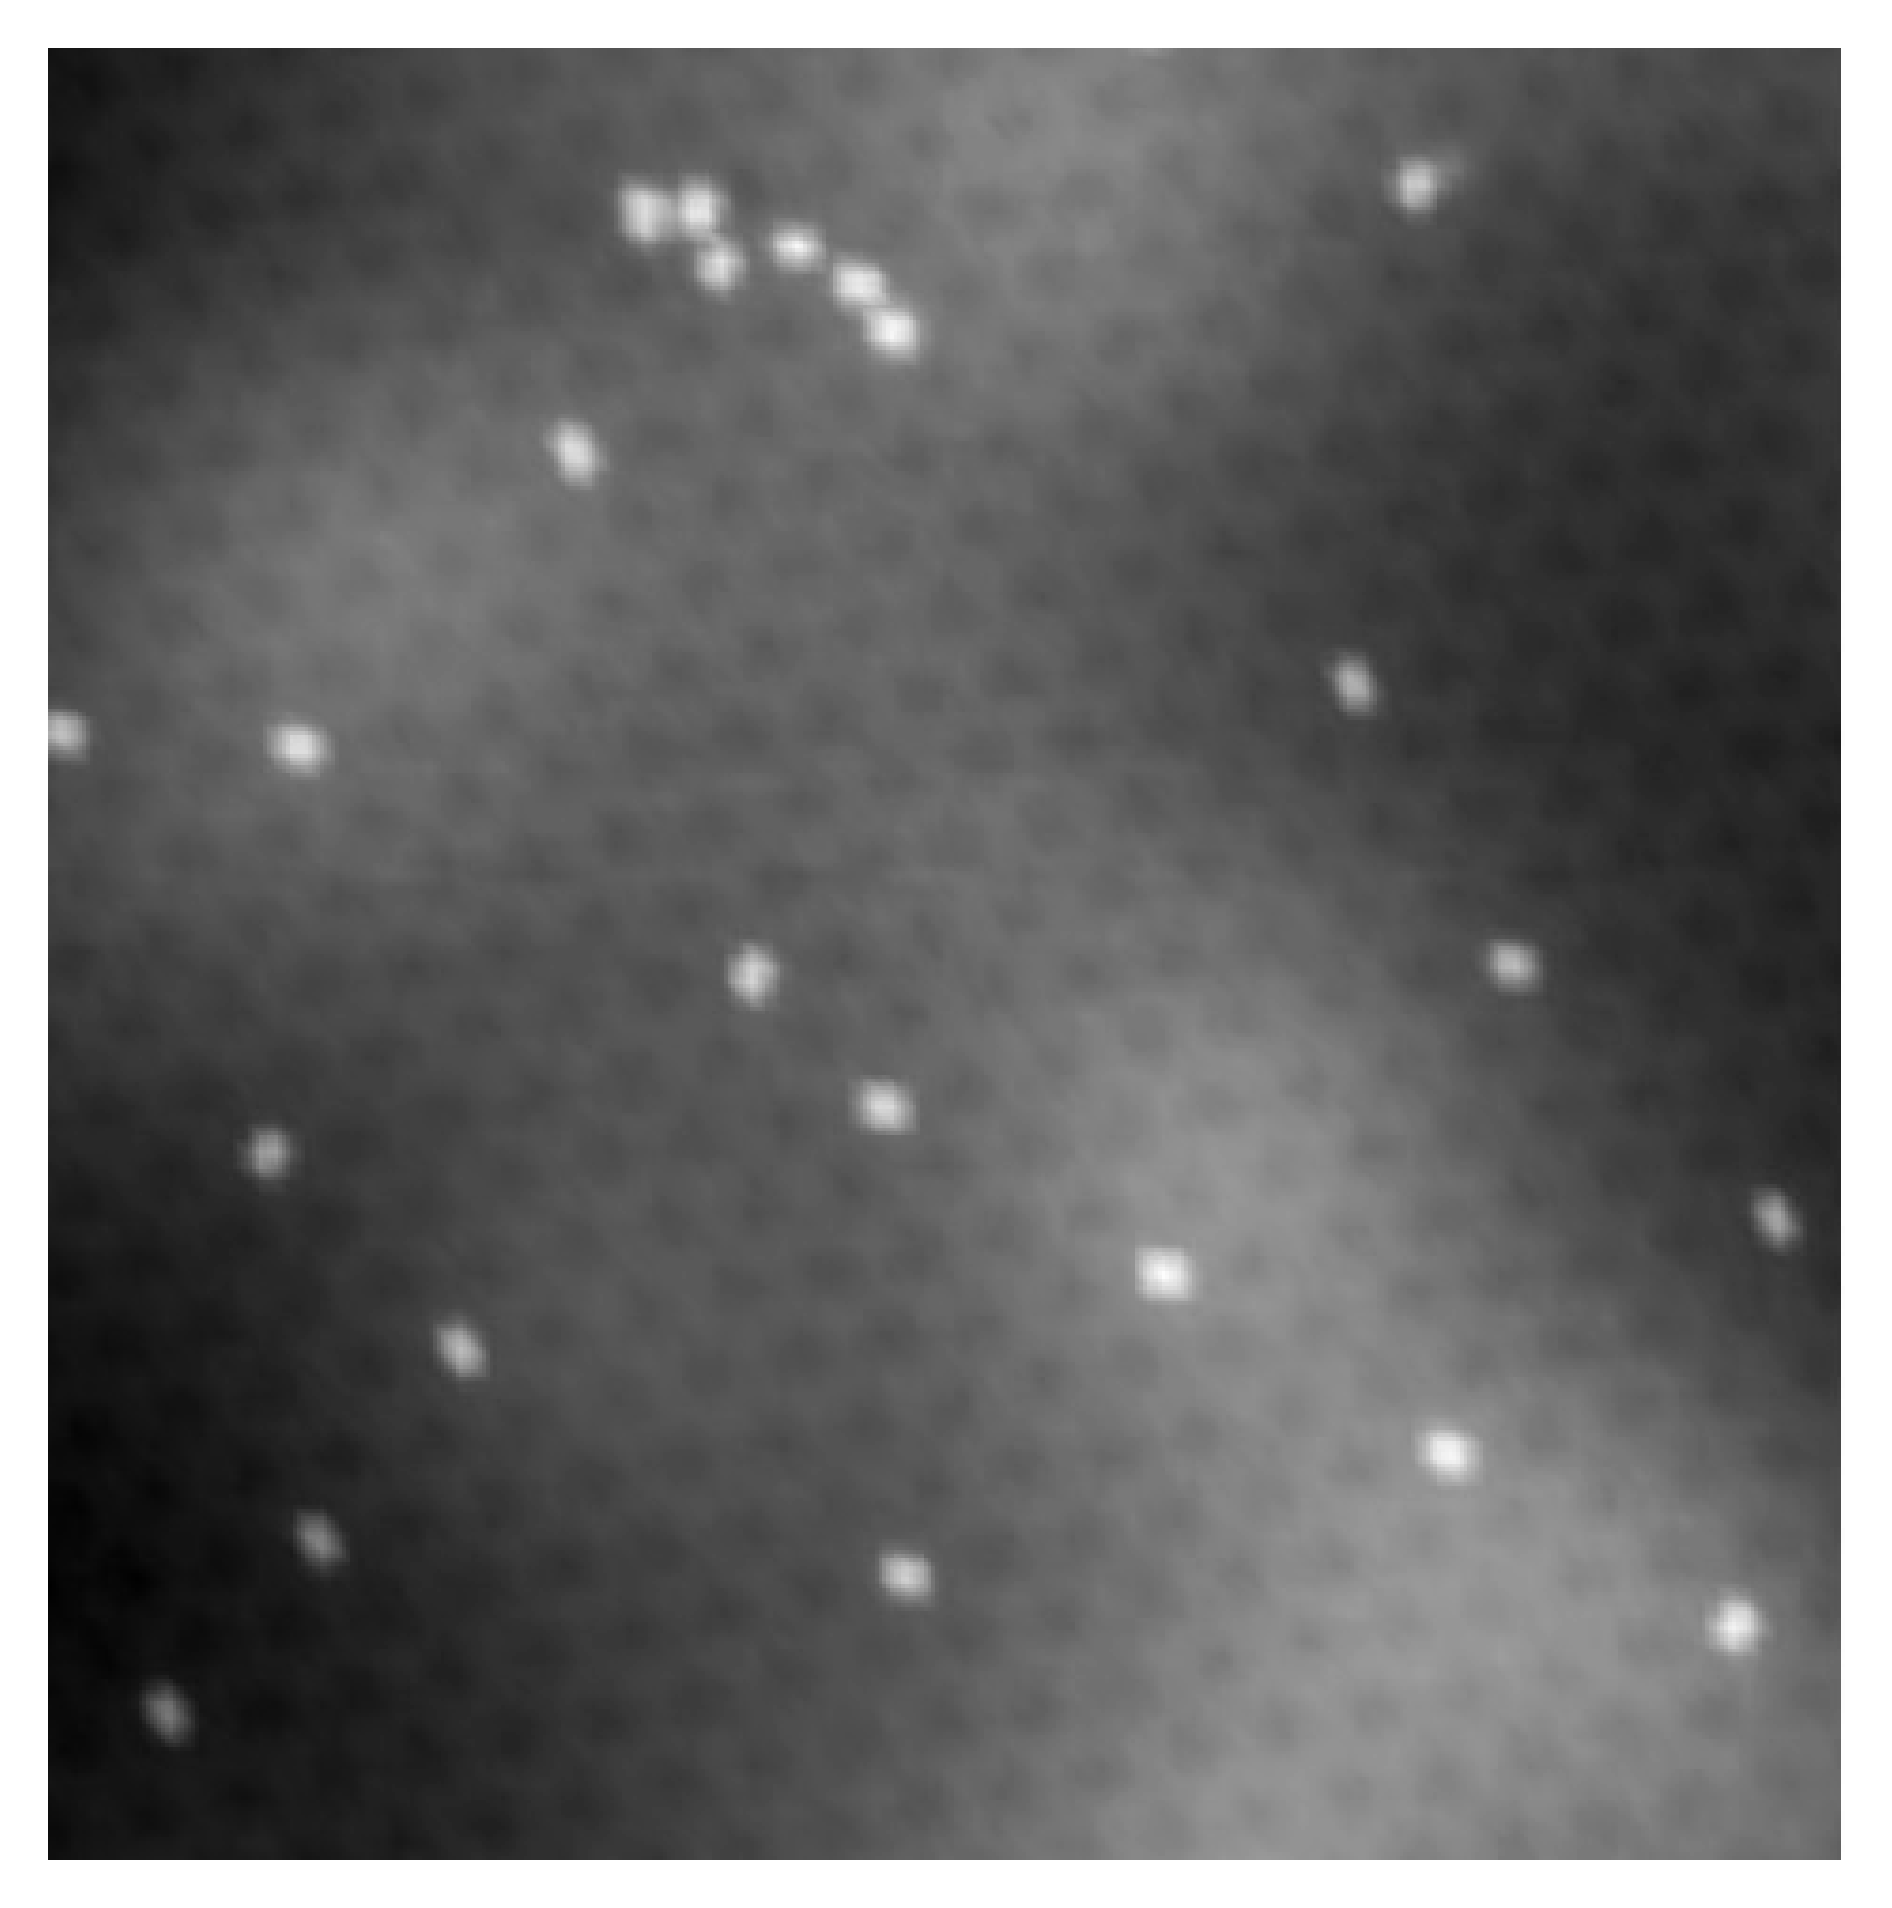

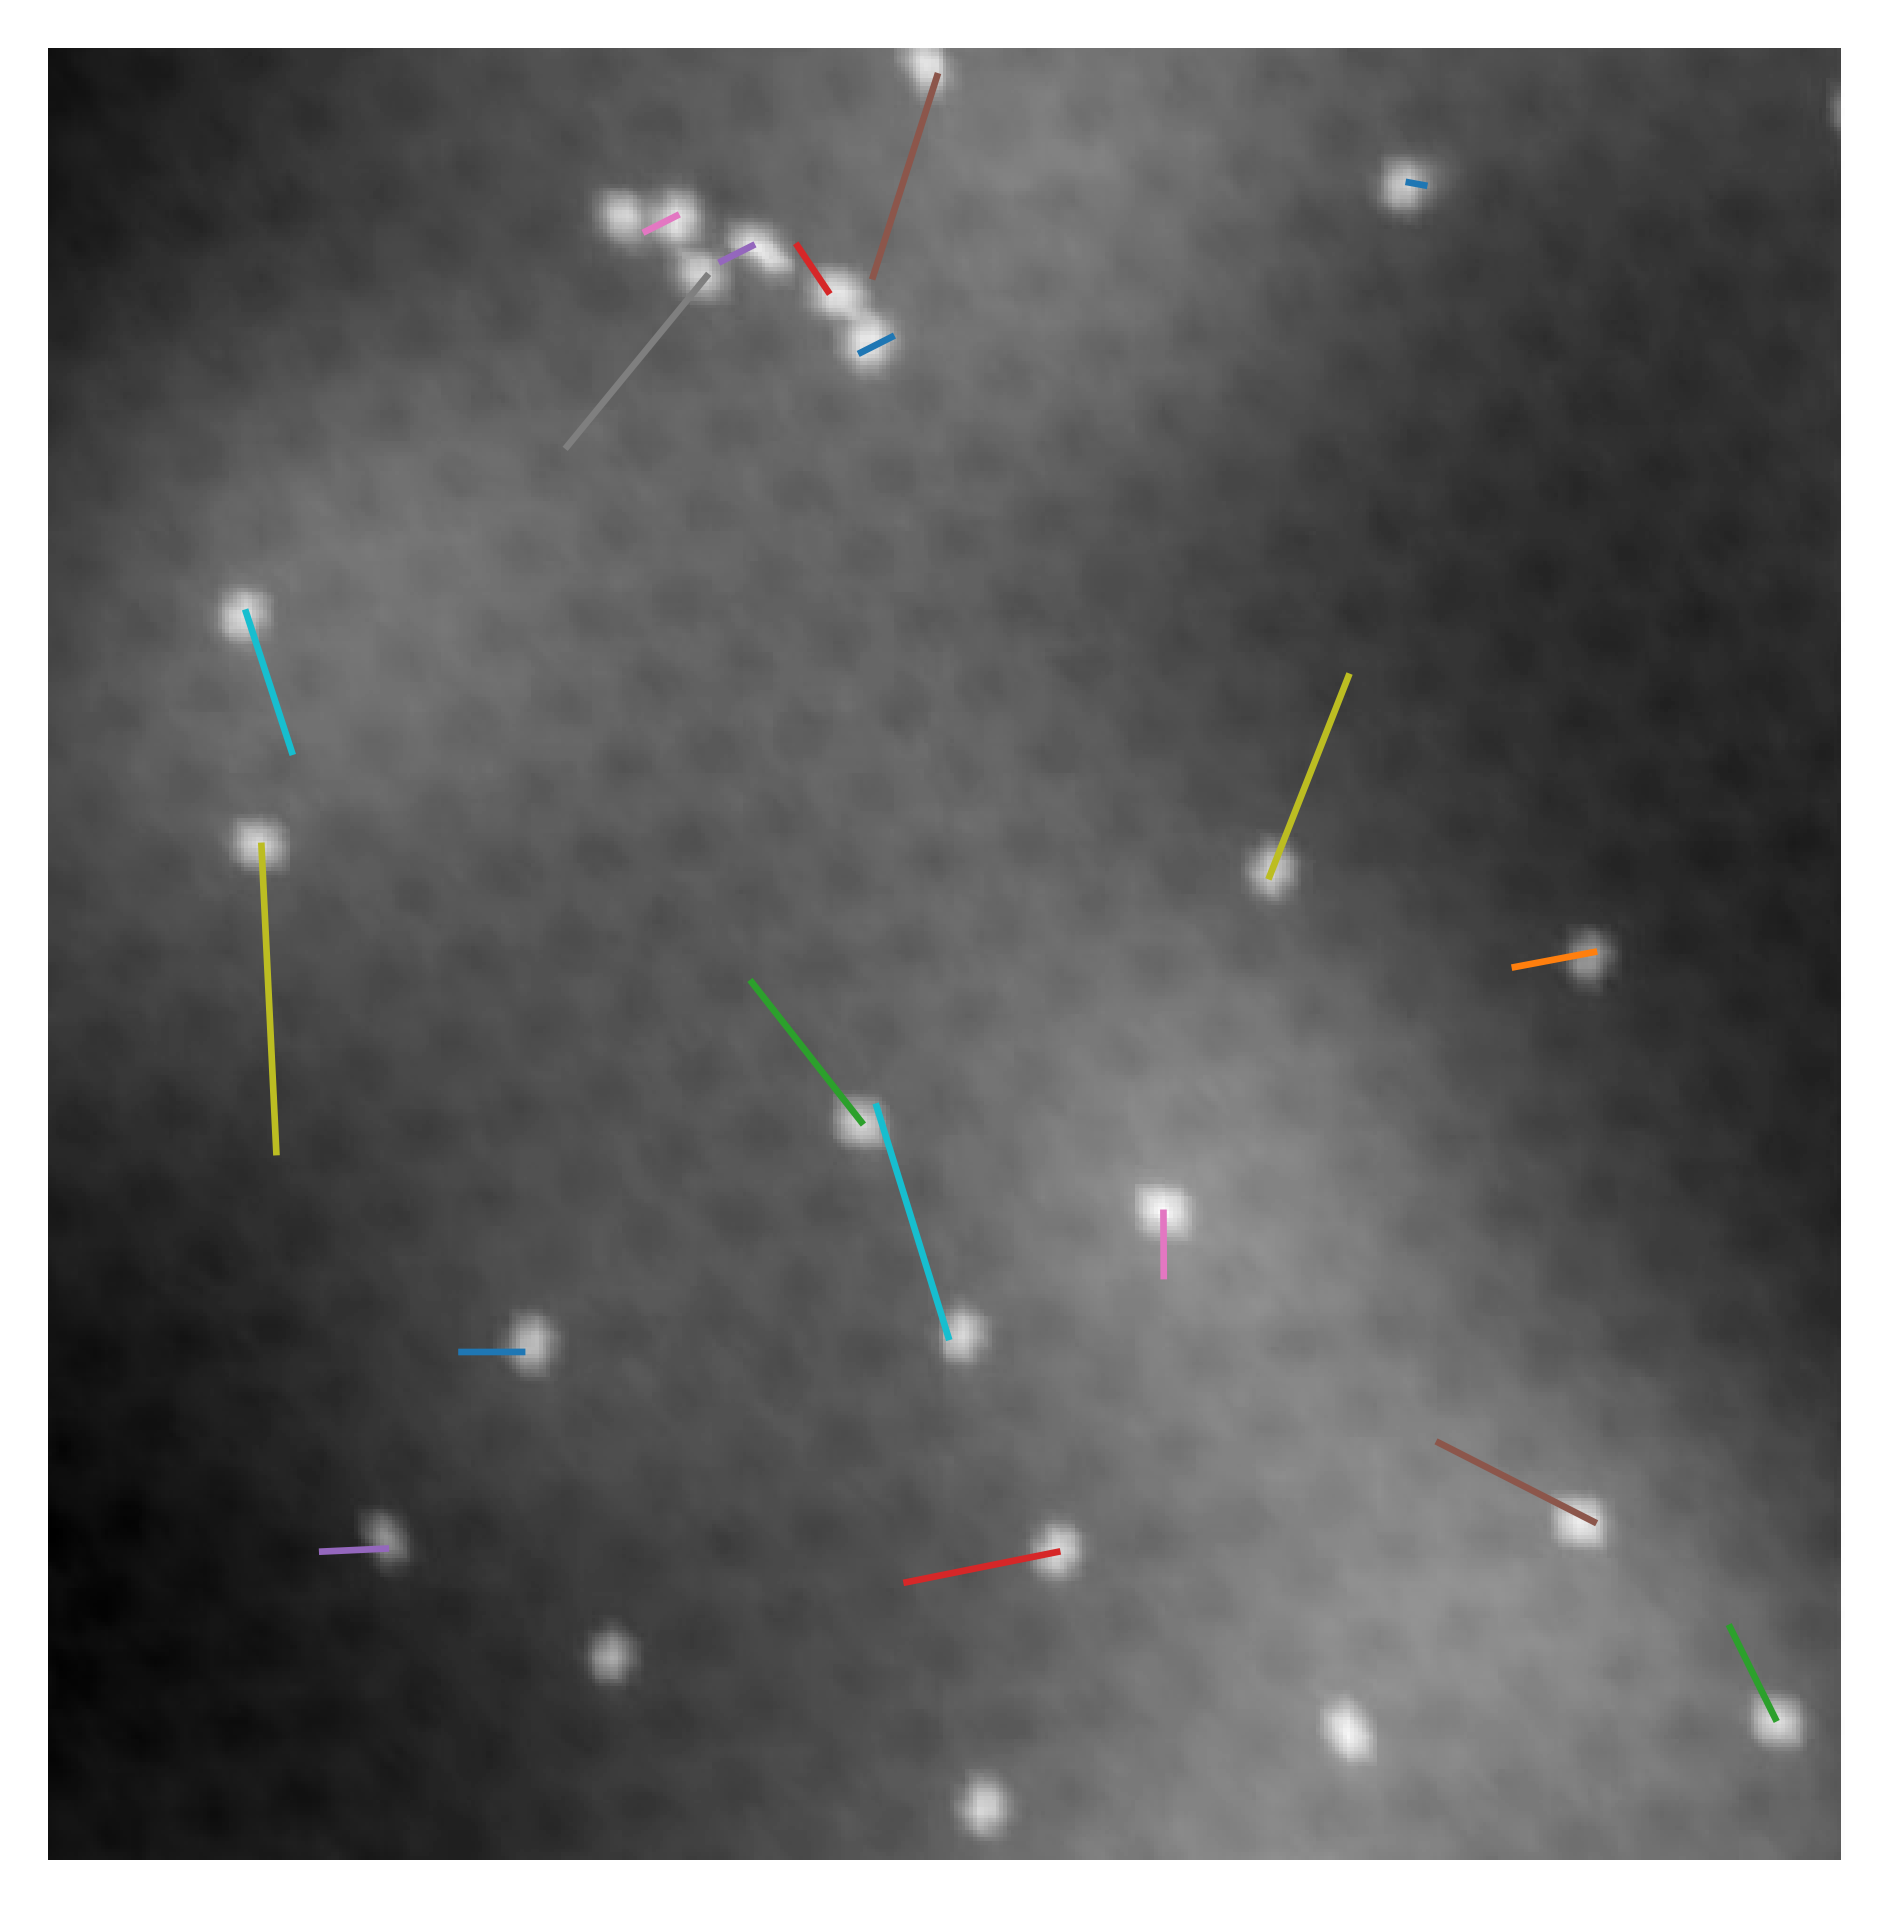

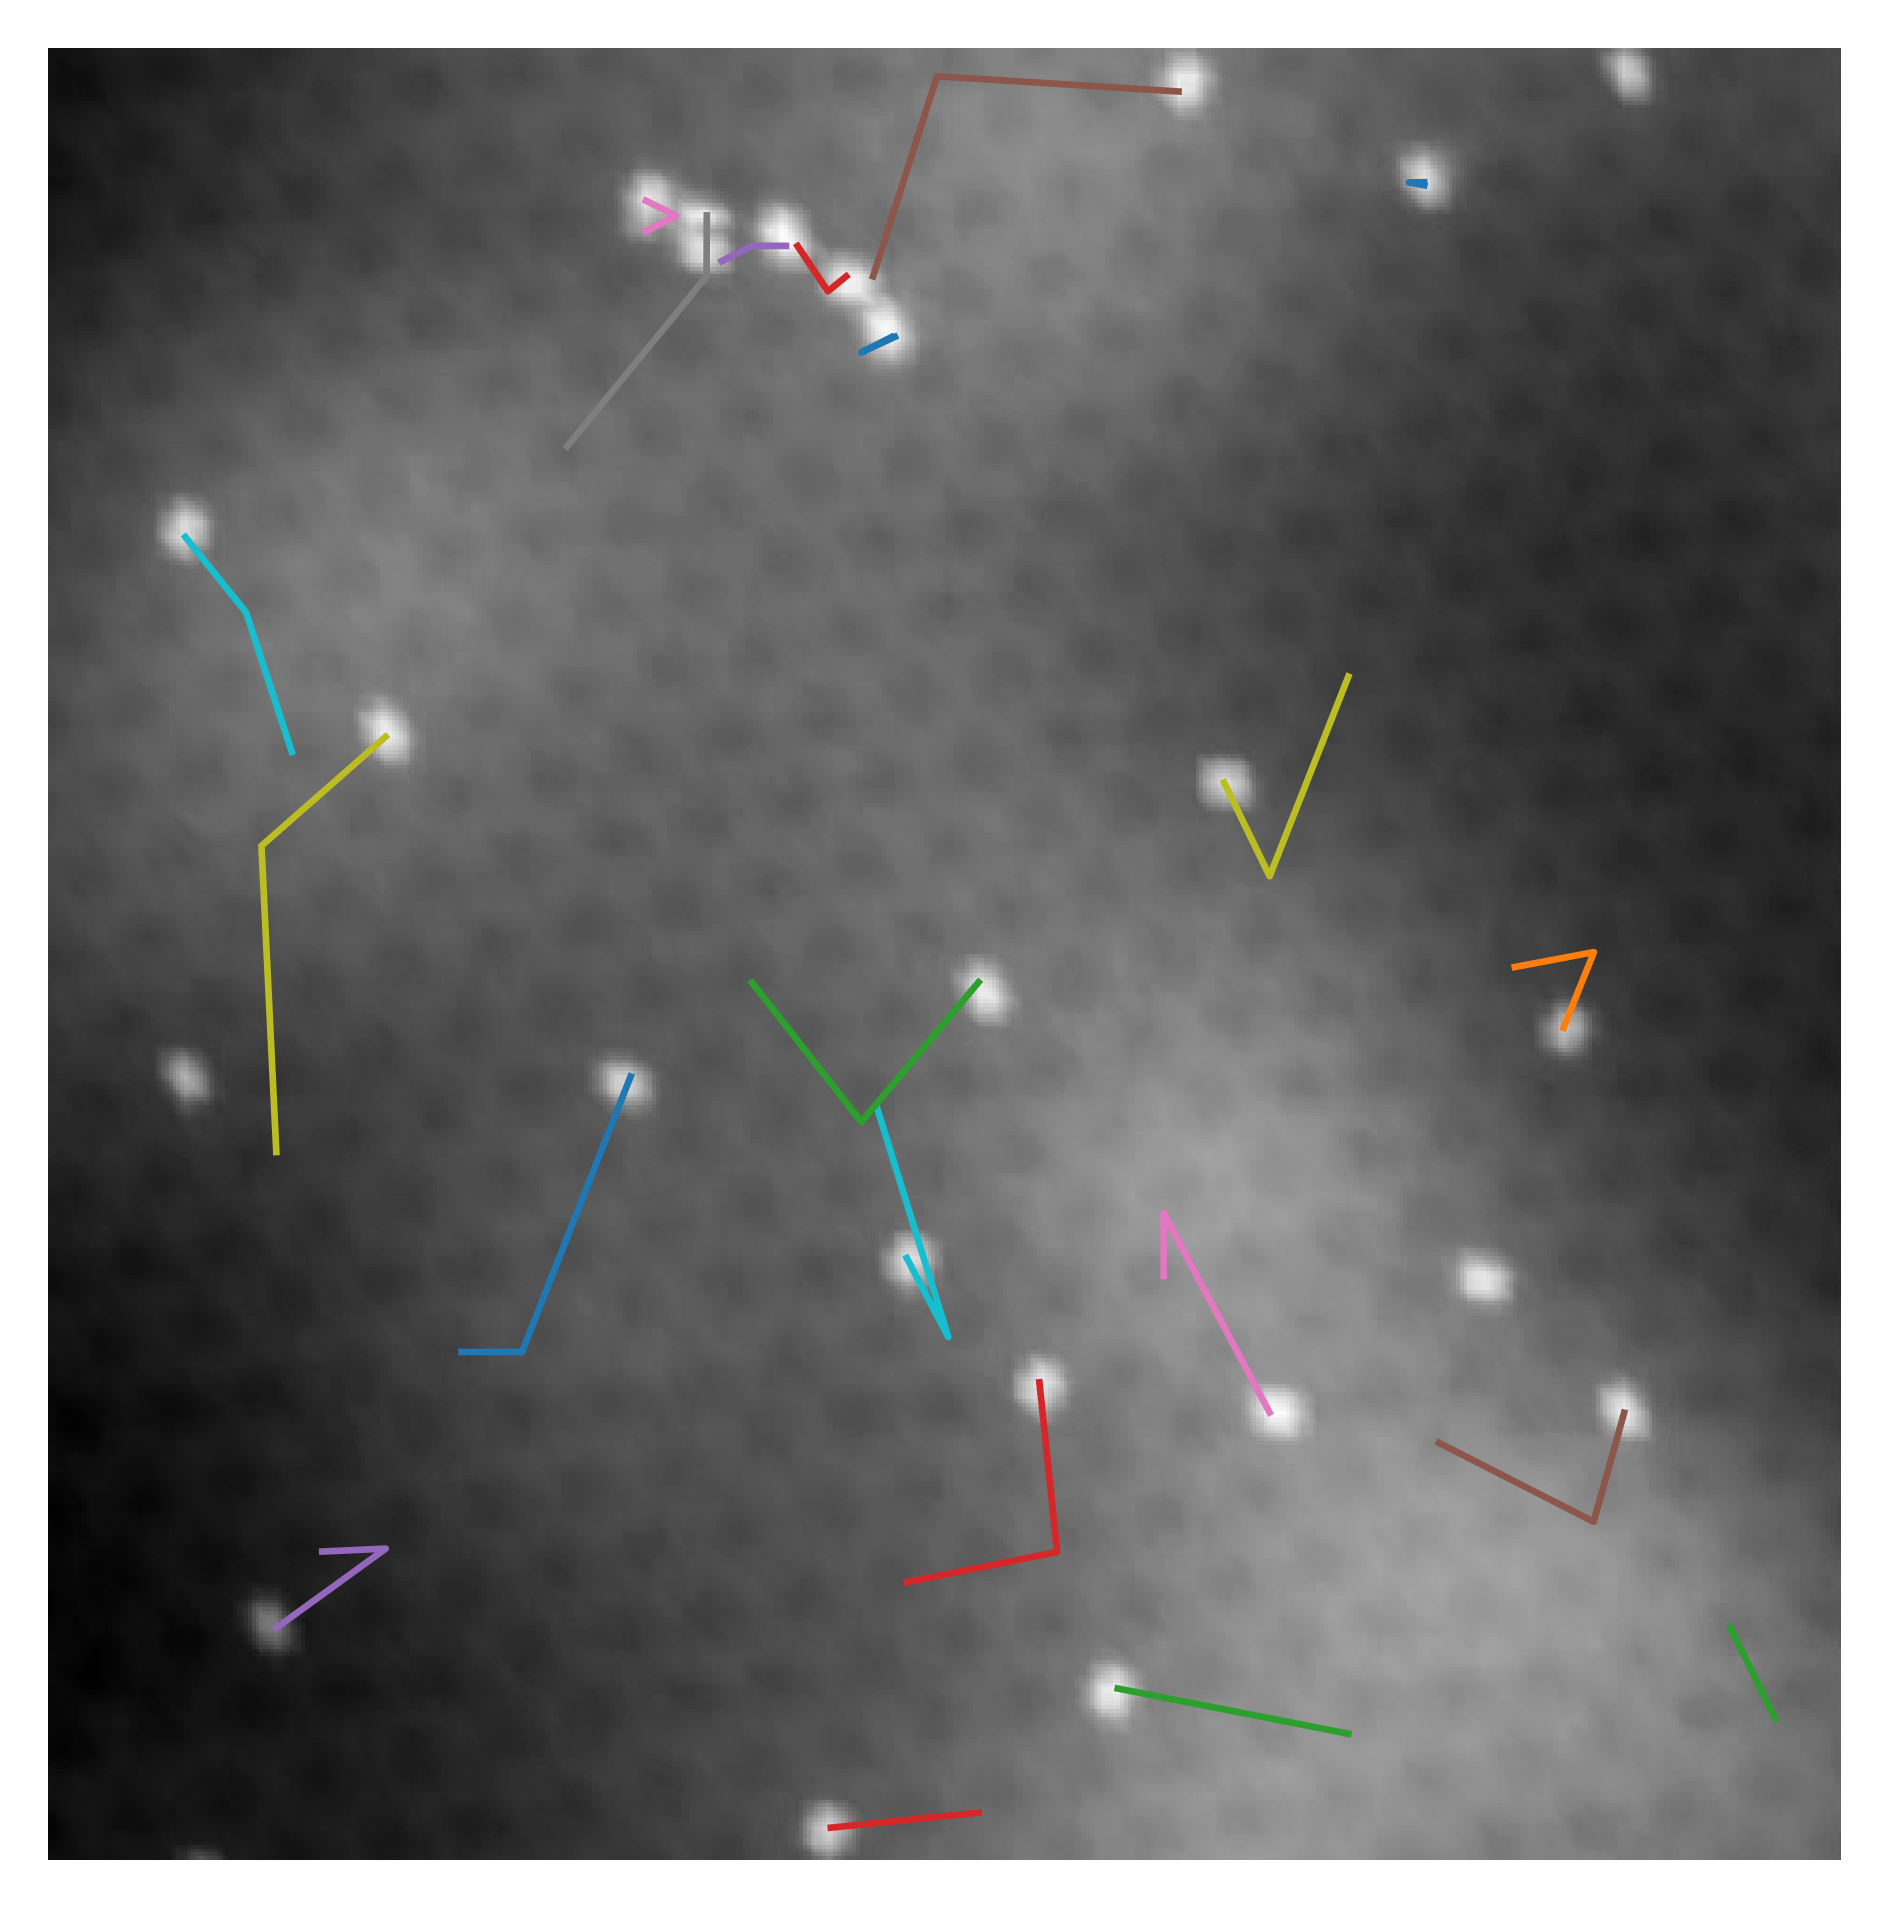

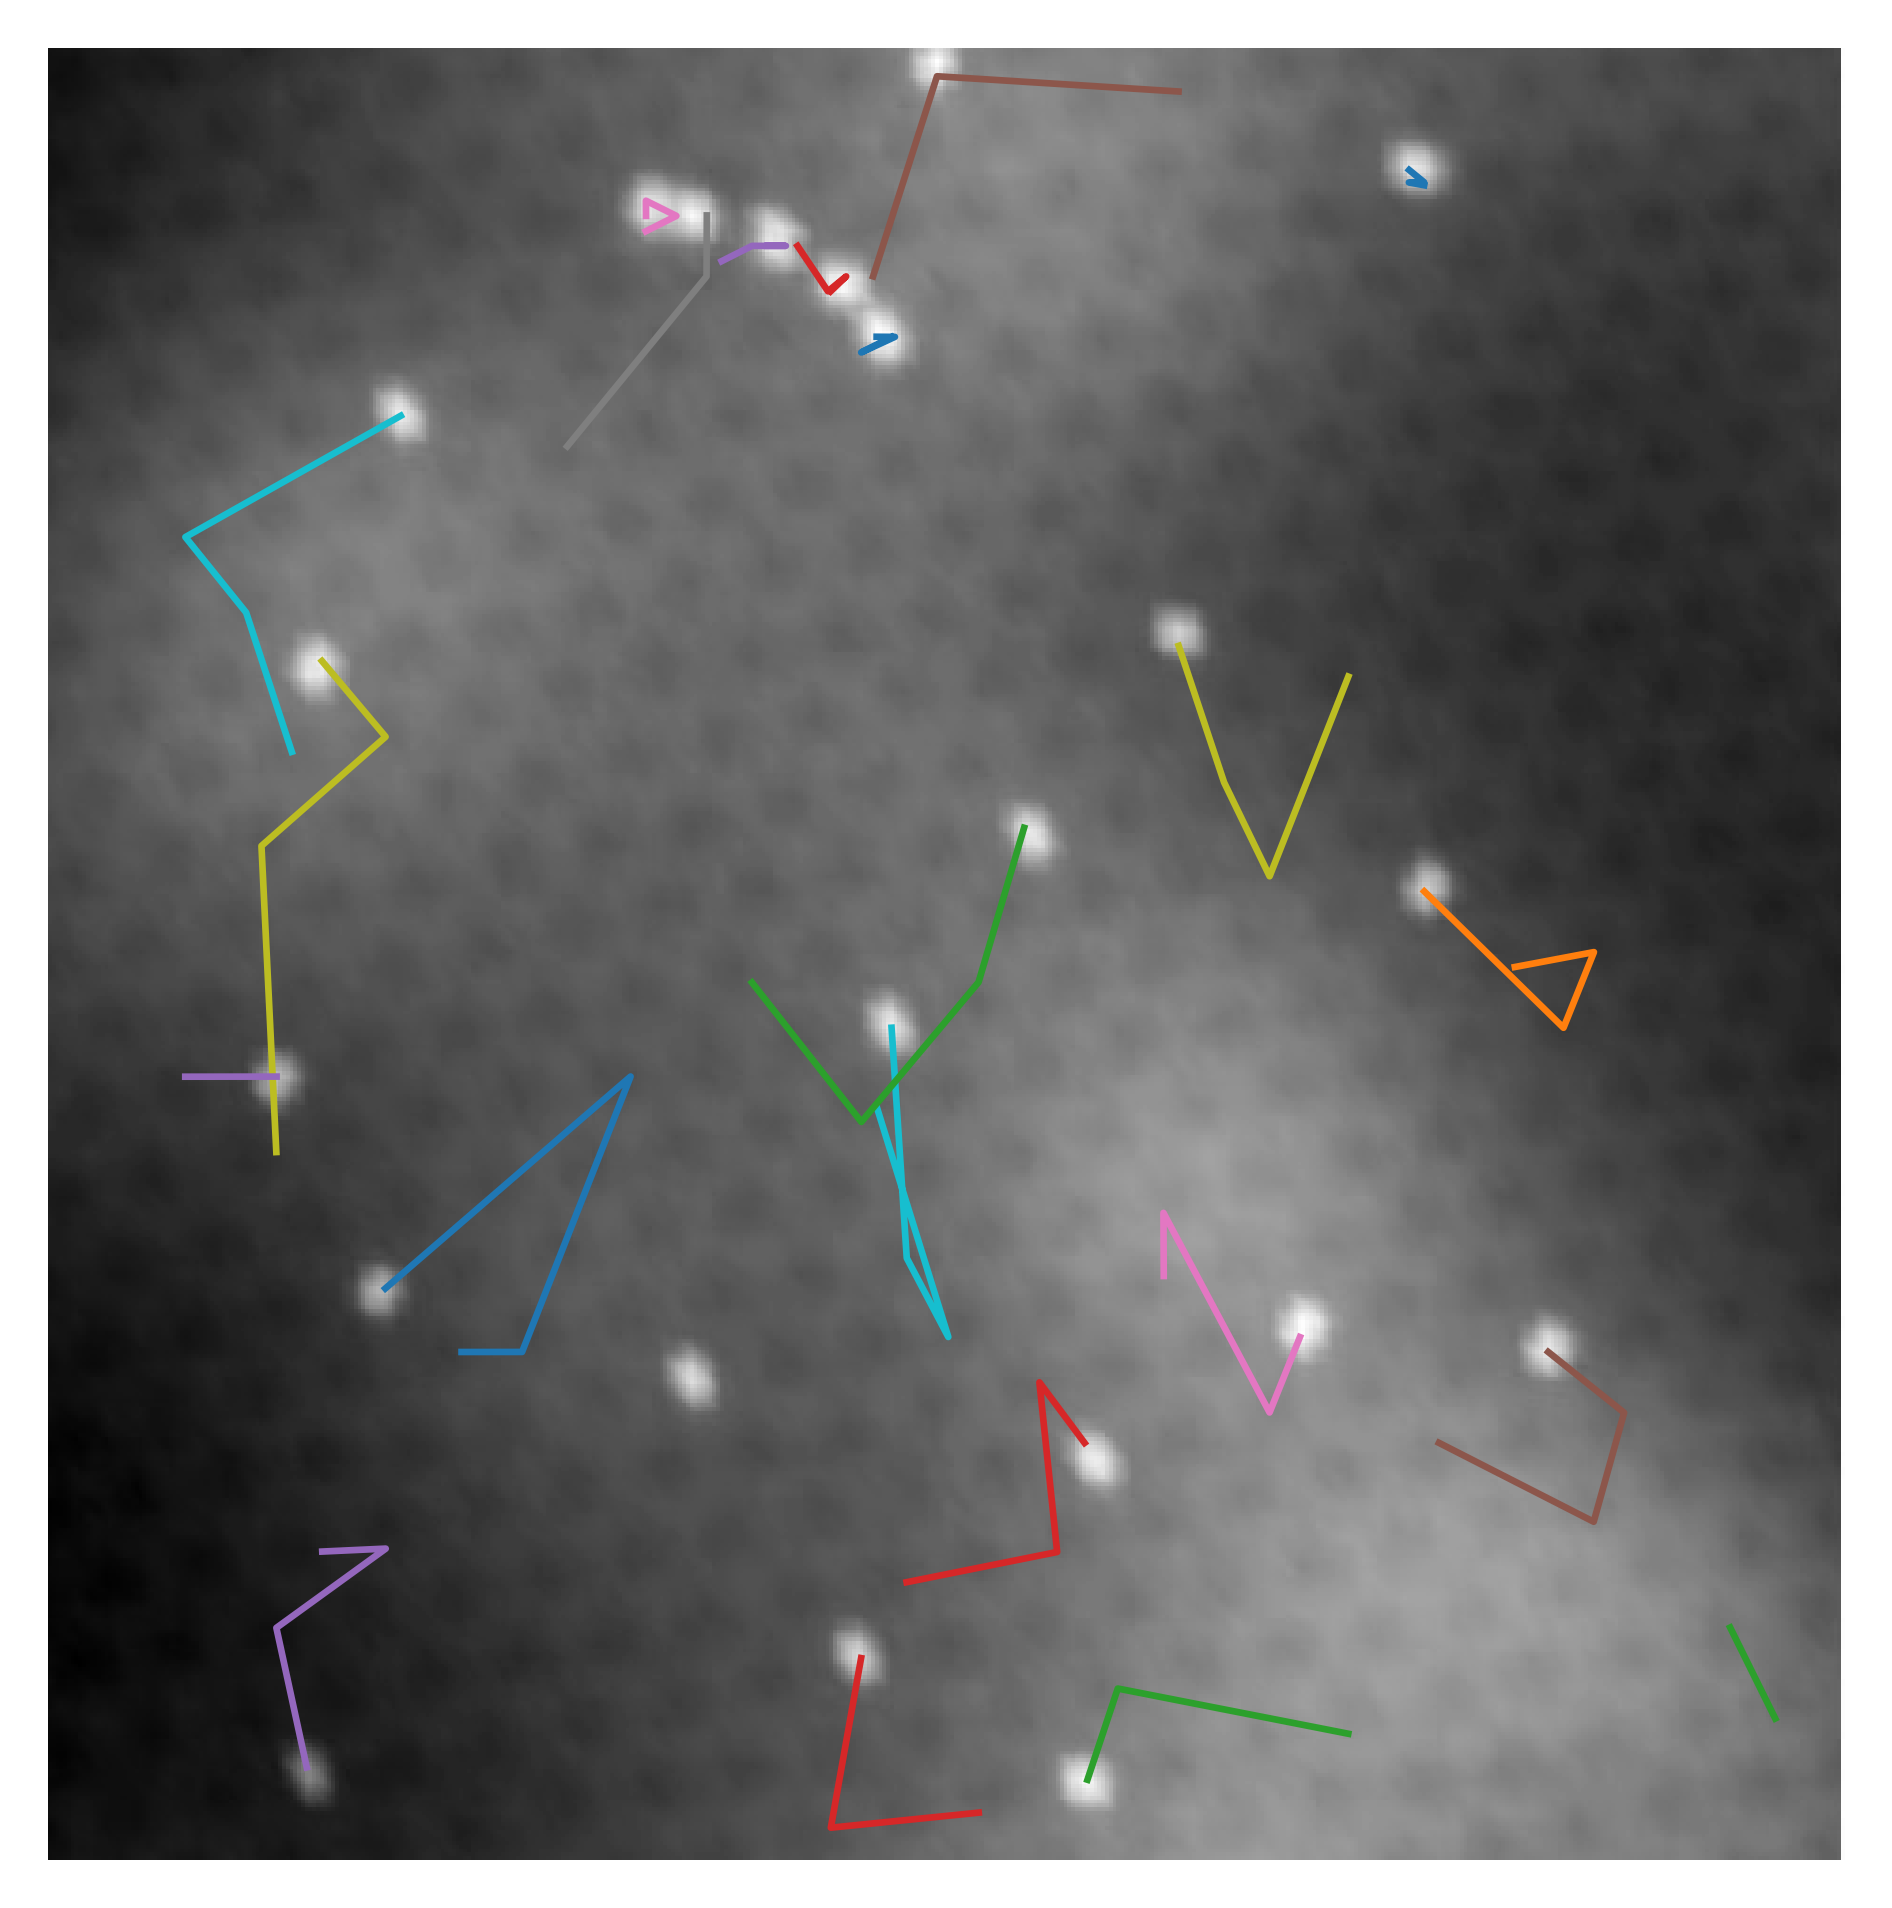

In [913]:
FOLDER_NAME = 'minibatch'
for i,frame in enumerate(frames):
    fig=plt.figure(dpi=480)
    ax1=plt.axes(frameon=False)
    tp.plot_traj(t2[(t2['frame']<=i)], superimpose=frame, ax=ax1);
    plt.axis('off')
#     fig.savefig(FOLDER_NAME + '/plot'+'{0:03}'.format(i)+'.png', bbox_inches='tight')

In [914]:
plt.figure()
#tp.plot_traj(t2, superimpose=frames[0]);
#tp.plot_traj(t2[t2['particle']==37], superimpose=frames[0]);

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [915]:
def pvariation(df, p, n, t=None):
    """p-variation for finite n.
    df: each trajectory data file
    p: power in p-variation formula
    n: n is the power in 2^n 
    t: max measurement time
    Frames beyond the highest power of 2 available are ignored.
    All intervals are constructed to be of equal length. T is assumed,
    without loss of generality, to equal the total number of frames included.
    
    """
    maxn = int(np.log2(len(df)) // 1)
    T = 2**maxn
    if t is None:
        t = T
    x = np.array(df['x'])
    y = np.array(df['y'])
    dt = T // 2**n
    ts = np.arange(2**n)*dt
    ts = ts[ts < t]  # Ignore frames greater than t
    total = 0.
    for i in range(len(ts) - 1):
        total += np.abs(x[ts[i+1]] - x[ts[i]])**p
    return total

In [916]:
d = tp.compute_drift(t2)

In [917]:
# window_devs = []
# for p in range(t2.frame.unique().size):
#     t3 = tp.subtract_drift(t2.copy(), d)
#     t3 = t3.drop(columns='frame').reset_index()
#     t3['x_inc'] = t3.groupby('particle')['x'].diff(periods=p)
#     t3 = t3[~t3['x_inc'].isna()]
#     window_devs.append(t3.shape[0])
#     devs = []
#     for f in t3.frame.unique():
#         devs.append(t3[t3.frame == f]['x_inc'].var())
#     window_devs.append(np.mean(devs))
# plt.plot(window_devs)

In [918]:
norm.fit(t3.x_inc)

(-0.4734772844046234, 2.870546582488861)

In [919]:
NM_PER_PIXEL = 73.8 / frames[0].shape[0]

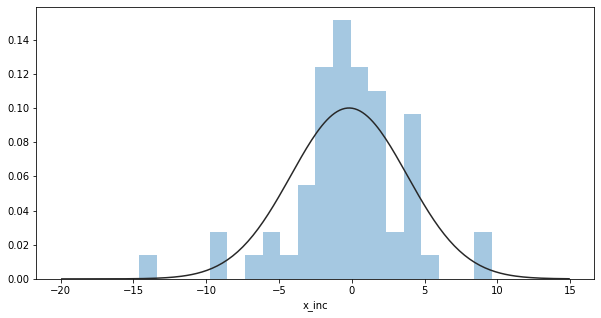

In [920]:
t3 = tp.subtract_drift(t2.copy(), d) * NM_PER_PIXEL
t3 = t3.drop(columns='frame').reset_index()
t3['x_inc'] = t3.groupby('particle')['x'].diff()
t3 = t3[~t3['x_inc'].isna()]

sns.distplot(t3.x_inc, fit=norm, norm_hist=False, bins=20, kde=False)

interactive(children=(IntSlider(value=4, description='x', max=29, min=1), Output()), _dom_classes=('widget-int…

<function __main__.g(x)>

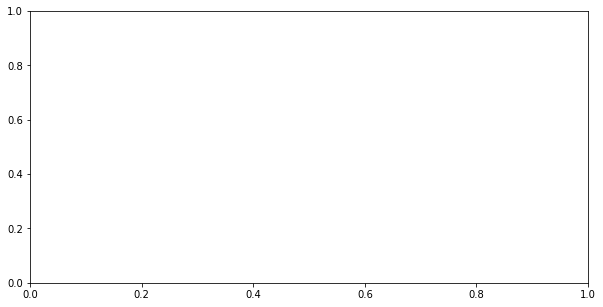

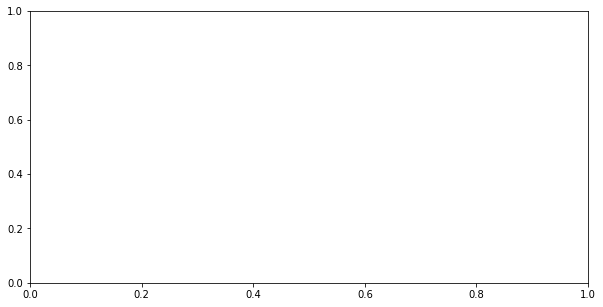

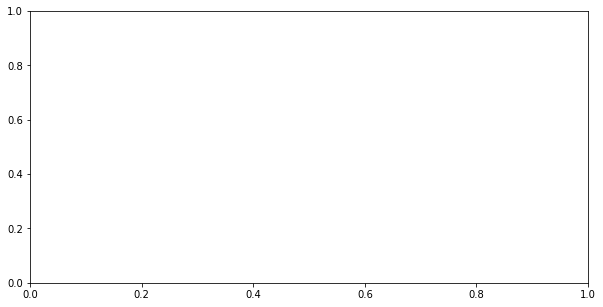

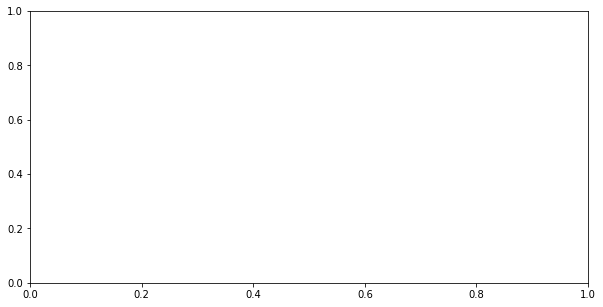

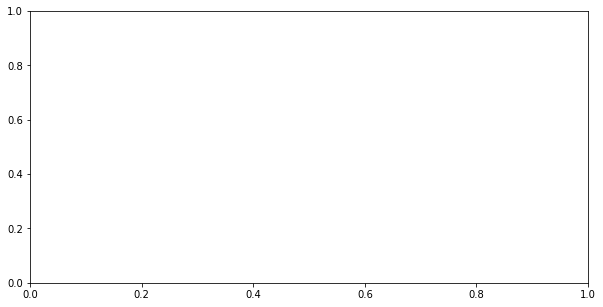

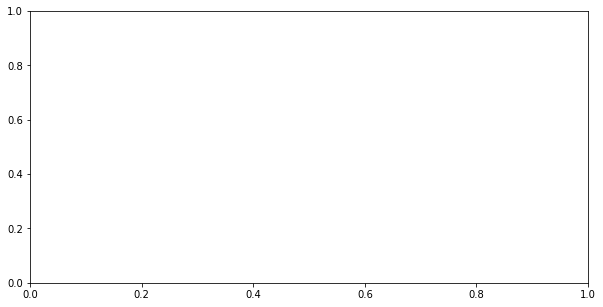

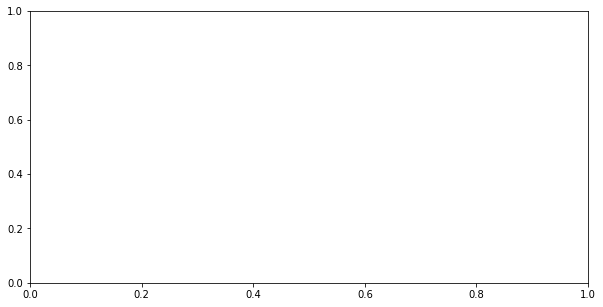

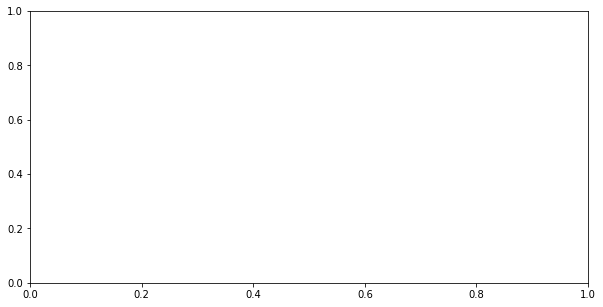

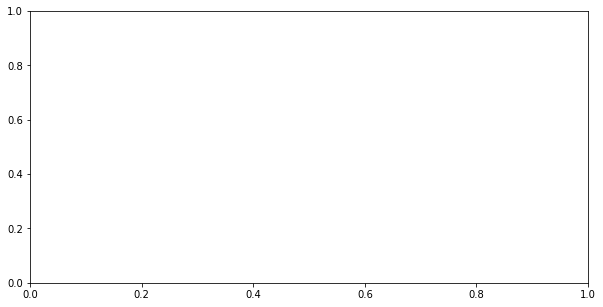

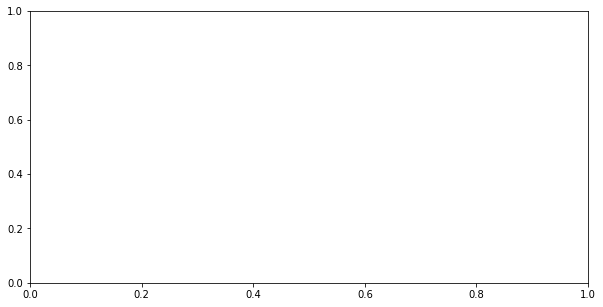

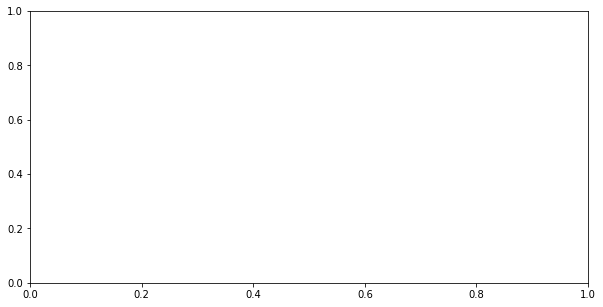

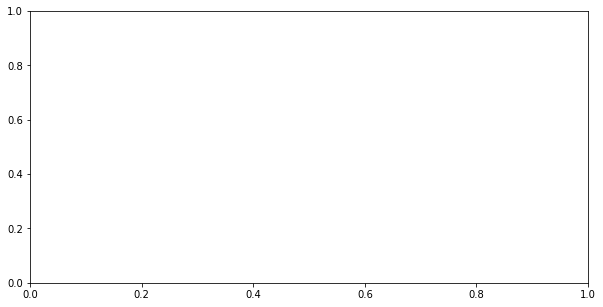

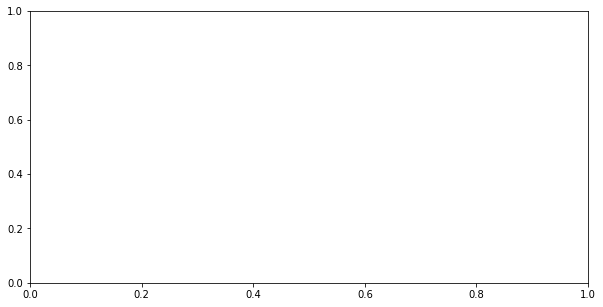

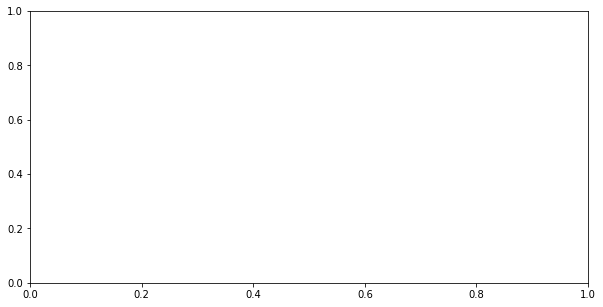

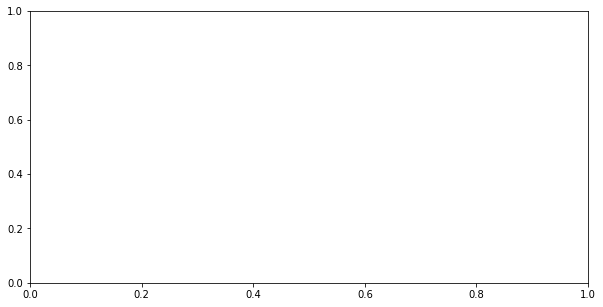

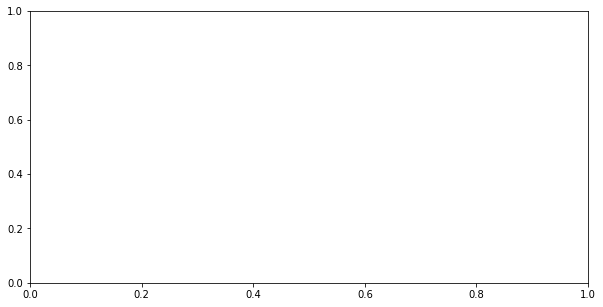

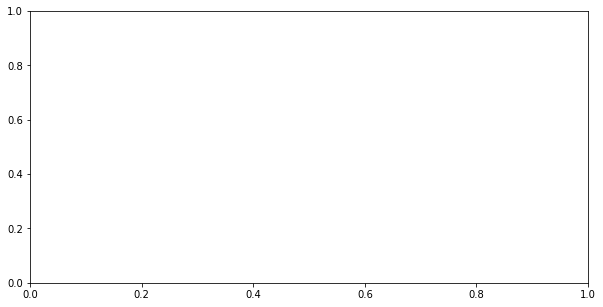

In [730]:
from ipywidgets import interactive
from scipy.stats import norm

t3 = tp.subtract_drift(t2.copy(), d)
t3 = t3.drop(columns='frame').reset_index()
t3['x_inc'] = t3.groupby('particle')['x'].diff()
t3 = t3[~t3['x_inc'].isna()]

def g(x):
    sns.distplot(t3[t3.frame == x]['x_inc'], fit=norm, kde=False)
    sns.distplot(t3[t3.frame == x]['x_inc'], hist=False, norm_hist=True, kde=True)
    plt.title("frame {}".format(x))
interactive_plot = interact(g, x=widgets.IntSlider(min=1, max=29, step=1, value=4));
interactive_plot

Text(0.5, 1.0, 'P-variation electromigration_8/Image_543.sxm - 552')

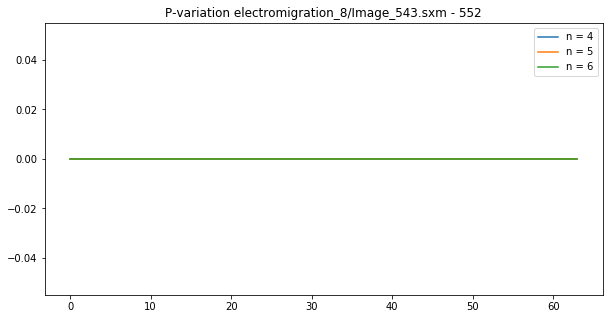

In [565]:
for j in [4, 5, 6]:
    v_t = []
    for i in range(2 ** 6):
        v_t.append(pvariation(tmp, 2, j, t=i))
    plt.plot(v_t, label="n = {}".format(j))
plt.legend()
plt.title('P-variation {} - {}'.format(BASE_FILENAME.format(n_range[0]), n_range[-1]))

In [582]:
d = tp.compute_drift(t2)
t3 = tp.subtract_drift(t2.copy(), d)
print(d)

               y          x
frame                      
1       1.222250  -2.345332
2       4.183036  -4.304501
3       4.536844  -2.513953
4       2.455900  -3.684296
5       3.019004  -3.855830
...          ...        ...
92    -20.990653 -52.823468
93    -23.382553 -51.405553
94    -25.501856 -51.909301
95    -23.990331 -53.812658
96    -24.552314 -53.735389

[96 rows x 2 columns]


In [608]:
t3.groupby('particle').filter(lambda x : len(x) > 80).drop(columns=['mass', 'size', 'ecc', 'signal', 'raw_mass', 'ep','frame']).reset_index().groupby('particle').size().size

12

bad: [31]


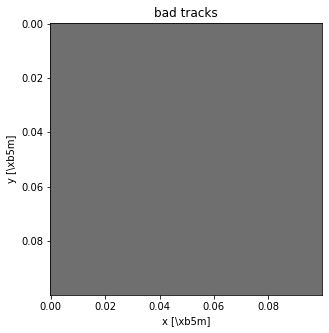

good: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 32, 34, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 32, 34]


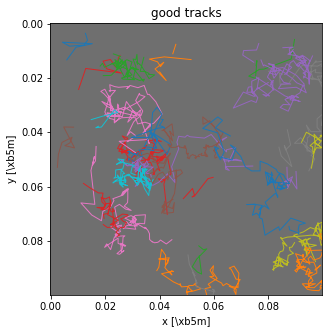

                    0         1         2         3         4         5   \
lag time [s]                                                               
1.0           0.000034  0.000005  0.000014  0.000010  0.000011  0.000022   
2.0           0.000059  0.000011  0.000029  0.000018  0.000018  0.000041   
3.0           0.000040  0.000015  0.000044  0.000027  0.000034  0.000050   
4.0           0.000031  0.000019  0.000057  0.000032  0.000050  0.000041   
5.0           0.000039  0.000024  0.000062  0.000043  0.000068  0.000040   
...                ...       ...       ...       ...       ...       ...   
92.0               NaN  0.000851       NaN  0.000578       NaN       NaN   
93.0               NaN  0.000853       NaN  0.000611       NaN       NaN   
94.0               NaN  0.000869       NaN  0.000660       NaN       NaN   
95.0               NaN  0.000811       NaN  0.000745       NaN       NaN   
96.0               NaN  0.000745       NaN  0.000773       NaN       NaN   

           

In [584]:
good_particles = []
bad_particles = []
t4 = t3.groupby('particle').filter(lambda x: len(x) >= 2)
paths = []
def is_track_good(track):
    global displacements
    x = track['x'].values
    y = track['y'].values
    denan = lambda x: x[~np.isnan(x)]
    x = denan(x) 
    y = denan(y) 
    pos = np.array([x,y]).T
    delta = pos[1:]-pos[:-1]
    mean_square = np.einsum("ij, ij->i", delta, delta)
    good = np.max(mean_square) > (2.0e-9/frames.meters_per_pixel)**2
    (good_particles if good else bad_particles).append(track['particle'].values[0])
    if(good):
        paths.append(delta)
    return good 
#movement_filter = t4.groupby('particle').apply(is_track_good).values
tm = t4.groupby('particle').filter(is_track_good)
print("bad:", bad_particles)
plt.figure()
plt.title("bad tracks")
tp.plot_traj(t4.groupby('particle').filter(lambda x: not is_track_good(x)), mpp=(frames.meters_per_pixel*1e6), superimpose=frames[0]);
print("good:", good_particles)
plt.title("good tracks")
# tp.plot_traj(tm, mpp=(frames.meters_per_pixel*1e6), superimpose=frames[0]);
# im = tp.imsd(tm, 1e6*frames.meters_per_pixel, 1)  # microns per pixel = 100/285., frames per second = 24
tp.plot_traj(t4, mpp=(frames.meters_per_pixel*1e6), superimpose=frames[0]);
im = tp.imsd(t4, 1e6*frames.meters_per_pixel, 1)  # microns per pixel = 100/285., frames per second = 24
#im = im.T[movement_filter].T 
print(im)

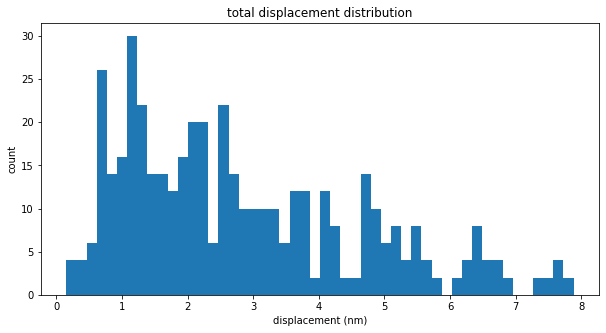

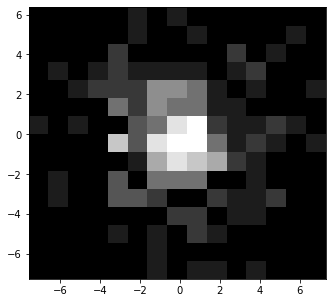

<Figure size 720x360 with 0 Axes>

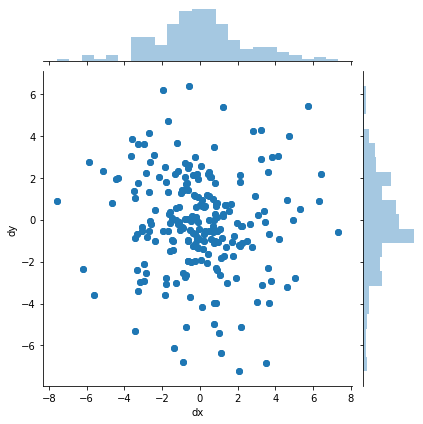

In [545]:
displacements = np.concatenate(paths)
dists = np.sqrt(np.einsum("ij, ij->i", displacements, displacements))
plt.title("total displacement distribution")
plt.xlabel("displacement (nm)")
plt.ylabel("count")
plt.hist(dists, bins=50);
fig, ax = plt.subplots()
ax.set_aspect('equal', 'box')
ax.hist2d(displacements.T[0], displacements.T[1], bins = 15);
plt.figure();
import seaborn as sns
displacement_df = pd.DataFrame(displacements, columns=['dx','dy'])
g = sns.jointplot(x="dx", y="dy", data=displacement_df)

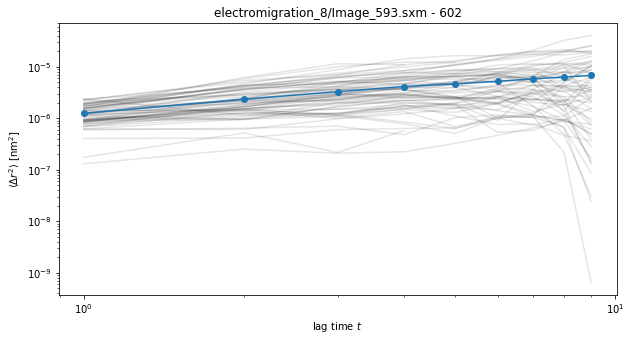

In [546]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$',
       title="{} - {}".format(BASE_FILENAME.format(n_range[0]), n_range[-1])
      )
ax.set_xscale('log')
ax.set_yscale('log')
em = tp.emsd(t4, frames.meters_per_pixel*1e6, 1) # microns per pixel = 100/285., frames per second = 24
# em = tp.emsd(tm, frames.meters_per_pixel*1e6, 1) # microns per pixel = 100/285., frames per second = 24
ax.plot(em.index, em, '-o')

In [ ]:
em = tp.emsd(tm, frames.meters_per_pixel*1e6, 1) # microns per pixel = 100/285., frames per second = 24
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
#ax.set(ylim=(1e-2, 10));

frame_id = 0
filename = frames.filenames[frame_id]
base_path = filename[:filename.find('/')]
path = os.path.join("output", base_path)
if not os.path.exists(path):
    os.makedirs(path)
fig.savefig(os.path.join(path, 'diffusion.png'))

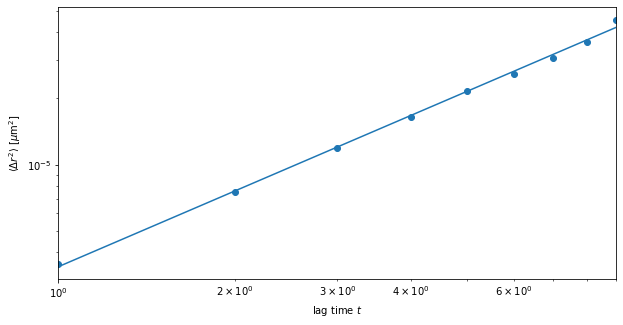

,n,A
msd,1.140487,0.000003


In [429]:
fig=plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]